In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from tqdm.auto import tqdm
tqdm.pandas() 

import sys, os
sys.path.append(os.path.abspath('../'))
from scripts.utils import create_dir, get_runtime
import time 
start_time = time.time()


In [2]:
df = pd.read_csv('../data/raw/rental/rental_data_cleaned_ptv.csv')
df

,lat,lng,address,bed,bath,car,type,rented_price,date,year,geometry,sa2_code_left,sa2_name_left,population,sa2_code_right,region,median_income,cpi,unemployment_rate,ptv_time
0,-37.813730,144.955580,"201/560 LONSDALE STREET, MELBOURNE",2.0,2.0,1.0,Unit/apmt,540,2021-08-01,2021,POINT (144.95558001 -37.81373001),206041505.0,Melbourne CBD - West,16098.0,206041505.0,Melbourne CBD - West,39300.0,3.5,4.200000,74.2
1,-37.810280,144.956670,"2007/228 ABECKETT STREET, MELBOURNE",2.0,2.0,0.0,Unit/apmt,360,2021-06-01,2021,POINT (144.95667001 -37.81028001),206041504.0,Melbourne CBD - North,17360.0,206041504.0,Melbourne CBD - North,29100.0,3.5,4.200000,26.1
2,-37.810280,144.956670,"2007/228 ABECKETT STREET, MELBOURNE",2.0,2.0,0.0,Unit/apmt,660,2020-06-01,2020,POINT (144.95667001 -37.81028001),206041504.0,Melbourne CBD - North,19155.0,206041504.0,Melbourne CBD - North,25000.0,0.9,5.166667,26.1
3,-37.809259,144.966567,"1808/318 RUSSELL STREET, MELBOURNE",2.0,2.0,0.0,Unit/apmt,650,2021-06-01,2021,POINT (144.9665671 -37.809259),206041503.0,Melbourne CBD - East,10119.0,206041503.0,Melbourne CBD - East,40810.0,3.5,4.200000,61.5
4,-37.809259,144.966567,"1808/318 RUSSELL STREET, MELBOURNE",2.0,2.0,0.0,Unit/apmt,720,2017-01-01,2017,POINT (144.9665671 -37.809259),206041503.0,Melbourne CBD - East,11881.0,206041503.0,Melbourne CBD - East,31790.0,1.9,5.608333,61.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132488,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,Unit/apmt,370,2019-09-01,2019,POINT (144.73271 -37.883631),213051581.0,Point Cook - North West,9739.0,213051581.0,Point Cook - North West,57433.0,1.8,5.175000,77.1
1132489,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,Unit/apmt,370,2019-08-01,2019,POINT (144.73271 -37.883631),213051581.0,Point Cook - North West,9739.0,213051581.0,Point Cook - North West,57433.0,1.8,5.175000,77.1
1132490,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,Unit/apmt,370,2019-07-01,2019,POINT (144.73271 -37.883631),213051581.0,Point Cook - North West,9739.0,213051581.0,Point Cook - North West,57433.0,1.8,5.175000,77.1
1132491,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,Unit/apmt,365,2018-06-01,2018,POINT (144.73271 -37.883631),213051581.0,Point Cook - North West,9678.0,213051581.0,Point Cook - North West,57001.0,1.8,5.283333,77.1


In [3]:
# drop unnecessary columns
df = df.drop(columns=[
    'lat', 'lng', 'address', 'date', 'geometry', 'sa2_code_left', 
    'sa2_name_left', 'sa2_code_right', 'region'
])
df

,bed,bath,car,type,rented_price,year,population,median_income,cpi,unemployment_rate,ptv_time
0,2.0,2.0,1.0,Unit/apmt,540,2021,16098.0,39300.0,3.5,4.200000,74.2
1,2.0,2.0,0.0,Unit/apmt,360,2021,17360.0,29100.0,3.5,4.200000,26.1
2,2.0,2.0,0.0,Unit/apmt,660,2020,19155.0,25000.0,0.9,5.166667,26.1
3,2.0,2.0,0.0,Unit/apmt,650,2021,10119.0,40810.0,3.5,4.200000,61.5
4,2.0,2.0,0.0,Unit/apmt,720,2017,11881.0,31790.0,1.9,5.608333,61.5
...,...,...,...,...,...,...,...,...,...,...,...
1132488,3.0,2.0,2.0,Unit/apmt,370,2019,9739.0,57433.0,1.8,5.175000,77.1
1132489,3.0,2.0,2.0,Unit/apmt,370,2019,9739.0,57433.0,1.8,5.175000,77.1
1132490,3.0,2.0,2.0,Unit/apmt,370,2019,9739.0,57433.0,1.8,5.175000,77.1
1132491,3.0,2.0,2.0,Unit/apmt,365,2018,9678.0,57001.0,1.8,5.283333,77.1


In [4]:
# Defining features and target
X = df.drop(columns=['rented_price'])  # Features
y = df['rented_price']  # Target


In [5]:
# Defining the model and Sequential Feature Selector
model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='backward')

# Defining the ColumnTransformer for one-hot encoding 'type' and standardizing numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bed', 'bath', 'car', 'year', 'population', 'median_income', 'cpi', 'unemployment_rate', 'ptv_time']),
        ('cat', OneHotEncoder(), ['type'])
    ]
)

X_preprocessed = preprocessor.fit_transform(X)
# Get feature names
numeric_features = ['bed', 'bath', 'car', 'year', 'population', 'median_income', 'cpi', 'unemployment_rate', 'ptv_time']
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['type'])
all_features = numeric_features + list(categorical_features)


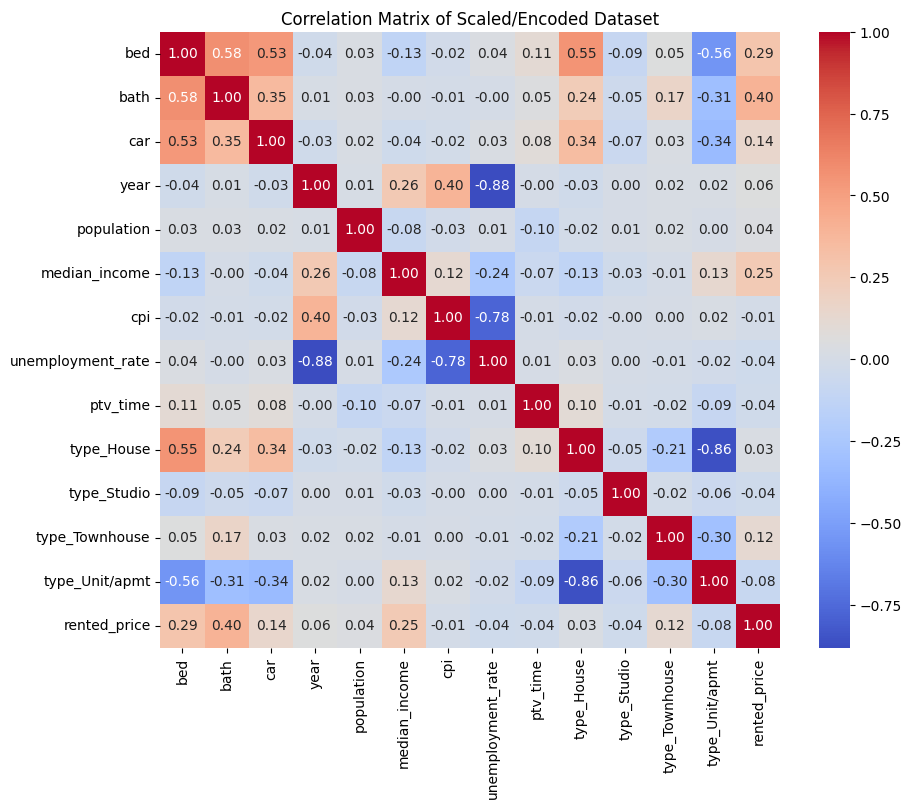

In [6]:
# Convert preprocessed data back into a DataFrame with proper feature names
preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_features)

# Compute correlation matrix (add back the target column)
preprocessed_df['rented_price'] = y.copy()
corr_matrix = preprocessed_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Scaled/Encoded Dataset")
plt.show()

In [7]:
# # Define the model and Sequential Feature Selector
# model = LinearRegression()
# sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='backward')

# # Creating the pipeline with preprocessing, feature selection, and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('feature_selection', sfs),
#     ('model', model)
# ])

# # Fitting the pipeline
# pipeline.fit(X, y)

# # Output selected feature indices
# selected_indices = sfs.get_support(indices=True)
# selected_feature_names = [all_features[i] for i in selected_indices]

# print(f"Selected feature names: {selected_feature_names}")

KeyboardInterrupt: 

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [9]:
# Initialize the ZeroR (DummyRegressor)
zero_r_model = DummyRegressor(strategy='mean')
# Fit the ZeroR model on the training data
zero_r_model.fit(X_train, y_train)

# Make predictions using ZeroR
y_pred_zero_r = zero_r_model.predict(X_test)

In [10]:
# Initialize the Linear Regression model
lr_model = LinearRegression()
# Fit the Linear Regression model on the training data
lr_model.fit(X_train, y_train)
# Make predictions using Linear Regression
y_pred_lr = lr_model.predict(X_test)

In [11]:
# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Fit the Random Forest model on the training data
rf_model.fit(X_train, y_train)
# Make predictions using Random Forest
y_pred_rf = rf_model.predict(X_test)

In [12]:
# Compute evaluation metrics for ZeroR
mse_zero_r = mean_squared_error(y_test, y_pred_zero_r)
r2_zero_r = r2_score(y_test, y_pred_zero_r)
# Compute evaluation metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
# Compute evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Output the results
print("ZeroR (Baseline) Model")
print(f"Mean Squared Error (MSE): {mse_zero_r}")
print(f"R-Squared (R2 Score): {r2_zero_r}\n")
print("Linear Regression Model")
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"R-Squared (R2 Score): {r2_lr}\n")
print("Random Forest Model")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-Squared (R2 Score): {r2_rf}")

ZeroR (Baseline) Model
Mean Squared Error (MSE): 18995.392449024363
R-Squared (R2 Score): -1.0631630686930293e-08

Linear Regression Model
Mean Squared Error (MSE): 14081.814301148406
R-Squared (R2 Score): 0.2586720970019062

Random Forest Model
Mean Squared Error (MSE): 5055.796437886069
R-Squared (R2 Score): 0.7338409035135726


In [16]:
# get variance of the target variable
variance = y.var()
print(f"Variance of the target variable: {variance}")

Variance of the target variable: 18951.042574336225
